<a href="https://colab.research.google.com/github/OsvaldoSan/TSC/blob/master/Unidad_1/Hello%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from datetime import datetime
from dateutil.relativedelta import relativedelta as rd

In [2]:
ini = datetime.now()

#### Carga y preparación de datos

In [3]:
bld = tfds.builder('mnist')
bld.download_and_prepare()
ds = bld.as_dataset(shuffle_files=False)
dstro = ds['train']
dsteo = ds['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
TAM_BUFF = 10000
TAM_LOTE = 64
NUM_EP = 2

In [5]:
# Estandarizar imagenes
dstr = dstro.map(lambda item:(tf.cast(item['image'],tf.float32)/255.0,tf.cast(item['label'],tf.int32)))
dste = dsteo.map(lambda item:(tf.cast(item['image'],tf.float32)/255.0,tf.cast(item['label'],tf.int32)))

In [7]:
tf.random.set_seed(0)
dstr = dstr.shuffle(buffer_size=TAM_BUFF,reshuffle_each_iteration=False) #Para que el shuffle?
dsva = dstr.take(10000).batch(TAM_LOTE)
dstr = dstr.skip(10000).batch(TAM_LOTE)

#### Construcción de la CNN

In [9]:
"""
Arquitectura 
28x28x1-->Conv(5x5x32)-->28x28x32-->Pooling(2x2)-->14x14x32-->
Conv(5x5x64)-->14x14x64-->Pooling(2x2)-->7x7x64-->Flat-->1024-->
FC1-->dropout(0.5)-->FC2-->10
"""

cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32,#?
                               kernel_size=(5,5),# El kernel de la convolución
                               strides=(1,1),#?
                               padding='same',#?
                               data_format='channels_last',#?
                               name='conv1',
                               activation='relu'
                              )) # Regresa una matriz de 28x28x32

cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                  name='pool1'
                                 ))# Reducción

cnn.add(tf.keras.layers.Conv2D(filters=64,
                               kernel_size=(5,5),
                               strides=(1,1),
                               padding='same',
                               data_format='channels_last',
                               name='conv2',
                               activation='relu'
                              ))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                  name='pool2'
                                 ))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1024,
                              name='fc1',
                              activation='relu'
                             ))# Son 1024 neuronas?

cnn.add(tf.keras.layers.Dropout(rate=0.5
                               ))# ¿Eliminar algunas partes para evitar el sobreajuste?

cnn.add(tf.keras.layers.Dense(units=10,
                              name='fc2',
                              activation='softmax'
                             ))# Son 10 neuronas de salida?

In [17]:
tf.random.set_seed(0)#¿Para que?
cnn.build(input_shape=(None,28,28,1))# ¿?

In [11]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              3212288   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

#### Entrenamiento del Modelo

In [18]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
           )

In [19]:
historia = cnn.fit(dstr,
                   epochs=NUM_EP,
                   validation_data=dsva,
                   shuffle=True)# ¿Por que shuffle?

Epoch 1/2
782/782 [==============================] - 133s 167ms/step - loss: 0.3189 - accuracy: 0.8964 - val_loss: 0.0461 - val_accuracy: 0.9861
Epoch 2/2
782/782 [==============================] - 128s 163ms/step - loss: 0.0469 - accuracy: 0.9857 - val_loss: 0.0379 - val_accuracy: 0.9892


#### Resultados

In [20]:
import matplotlib.pyplot as plt
import numpy as np

hist = historia.history
x_arr = np.arange(len(hist['loss']))+1

In [24]:
hist

{'accuracy': [0.9555000066757202, 0.9862599968910217],
 'loss': [0.13977403938770294, 0.04338479042053223],
 'val_accuracy': [0.9861000180244446, 0.9891999959945679],
 'val_loss': [0.04609701782464981, 0.03786396607756615]}

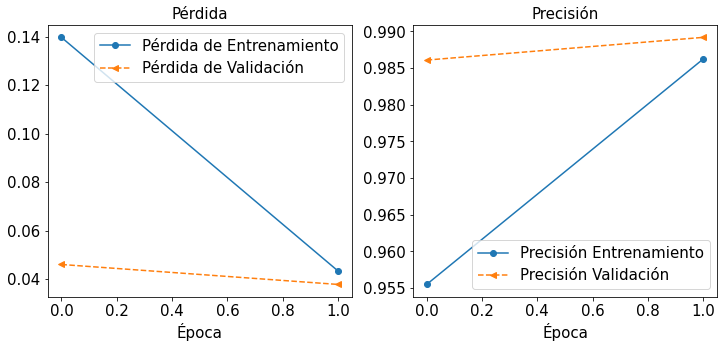

In [25]:

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_accuracy'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()

In [26]:
resultados_prueba = cnn.evaluate(dste.batch(20))
print('Precisión Prueba %.4f'%resultados_prueba[1])

500/500 [==============================] - 8s 17ms/step - loss: 0.0261 - accuracy: 0.9908
Precisión Prueba 0.9908


In [27]:
resultados_prueba

[0.02612023986876011, 0.9908000230789185]

tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


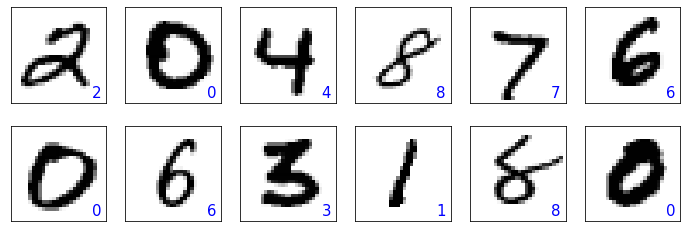

In [28]:
lote_prueba = next(iter(dste.batch(12)))
pred = cnn(lote_prueba[0])

pred = tf.argmax(pred,axis=1)
print(pred)
fig = plt.figure(figsize=(12,4))
for i in range(12):
    ax = fig.add_subplot(2,6,i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = lote_prueba[0][i,:,:,0]
    ax.imshow(img,cmap='gray_r')
    ax.text (0.9,0.1,'{}'.format(pred[i]),
             size=15,
             color='blue',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)
plt.show()

In [ ]:
rd(datetime.now(),ini)

relativedelta(minutes=+13, seconds=+13, microseconds=+889448)